In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore', category=Warning)

## Preprocessing

In [3]:
df = pd.read_csv('data_filtered (1).csv')

In [4]:
df.head(15)

,HR,SpO2,Age,Gender,BMI,Anomaly
0,85,96,70,Male,40.1,True
1,83,94,70,Male,40.1,True
2,80,94,70,Male,40.1,True
3,79,96,70,Male,40.1,True
4,84,96,70,Male,40.1,True
5,78,95,70,Male,40.1,True
6,78,95,70,Male,40.1,True
7,83,94,70,Male,40.1,True
8,78,96,70,Male,40.1,True
9,79,97,70,Male,40.1,True


In [5]:
df.dropna(inplace=True)

df['Gender'] = df['Gender'].map({'Female': 1, 'Male': 0})

#Drop the id column
#df.drop('ID', axis=1, inplace=True)

In [6]:
X = df[['HR', 'SpO2','Age','Gender','BMI']]
y = df['Anomaly']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## ML Models

### Logestic Regression

In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9886363636363636

### Random Forest

In [9]:
rf_model = RandomForestClassifier(n_estimators=10)
rf_model.fit(X_train, y_train)
 
rf_model.score(X_test, y_test)

1.0

### Decision Tree

In [10]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

dt_model.score(X_test, y_test)

1.0

### K-nearest neighbor with cross validation

In [11]:
n_neighbors_range = range(1, 50)

accuracies = []

for n_neighbors in n_neighbors_range:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)

    # Calculate the accuracy of the model using 5-fold cross-validation
    accuracy = cross_val_score(knn_model, X_test, y_test, cv=5).mean()
    accuracies.append(accuracy)

# Find the index of the highest accuracy
best_index = accuracies.index(max(accuracies))

print("Best n_neighbors:", n_neighbors_range[best_index])
print("Accuracy:", max(accuracies))

Best n_neighbors: 1
Accuracy: 0.9888888888888889


### Support vector machine

In [12]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)

svm_score = svm_model.score(X_test, y_test)
print("SVM model score:", svm_score)

SVM model score: 1.0


### Logistic Regression with K-folds cross-validation

In [13]:
model = LogisticRegression()

# Define no. of folds for cross-validation
n_splits = 10

X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

# Reset indices of training and test sets
X_train = X_train_df.reset_index(drop=True)
X_test = X_test_df.reset_index(drop=True)

# Perform k-fold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True)

accuracies = []
auc_values = []

for train_index, test_index in kf.split(X_train, y_train):
    # Split the data into training and test sets
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(X_train_fold, y_train_fold)

    y_pred_class = model.predict(X_test_fold)
    accuracy = accuracy_score(y_test_fold, y_pred_class)

    # Calculate the accuracy and AUC & Removing nans before calculating AUC
    y_test_fold_filtered = y_test_fold[~np.isnan(y_test_fold)]
    y_pred_class_filtered = y_pred_class[~np.isnan(y_test_fold)]
    auc = roc_auc_score(y_test_fold_filtered, y_pred_class_filtered)

    accuracies.append(accuracy)
    auc_values.append(auc)

average_accuracy = sum(accuracies) / len(accuracies)
average_auc = sum(auc_values) / len(auc_values)

print("Average accuracy:", average_accuracy)
print("Average AUC:", average_auc)


Average accuracy: 0.9828571428571429
Average AUC: 0.9813095238095239


### Logistic Regression with K-folds cross-validation and grid search to find the best model parameters

In [14]:
# hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True))
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_class = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_class)

# Calculate AUC
y_test_fold_filtered = y_test[~np.isnan(y_test)]
y_pred_class_filtered = y_pred_class[~np.isnan(y_test)]
auc = roc_auc_score(y_test_fold_filtered, y_pred_class_filtered)

print("Average accuracy:", accuracy)
print("Average AUC:", auc)
print("Best parameters:", best_params)

Average accuracy: 1.0
Average AUC: 1.0
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


### Store chosen model for deployment 

In [16]:
from sklearn.ensemble import RandomForestClassifier
import joblib

rf_model = RandomForestClassifier(n_estimators=10)
rf_model.fit(X_train, y_train)

filename = 'rf_model.pkl'
joblib.dump(rf_model, filename)

['rf_model.pkl']

## Visualization and Model Comparison

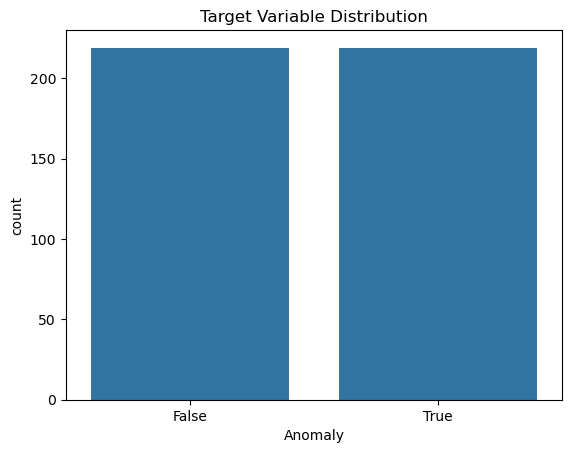

In [17]:
sns.countplot(x='Anomaly', data=df)
plt.title('Target Variable Distribution')
plt.show()

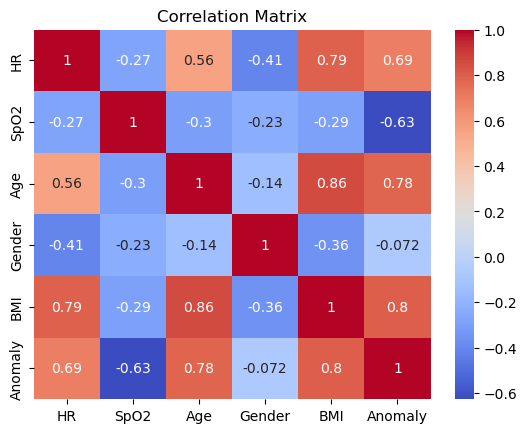

In [18]:
# Visualize correlations between features
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Models Comparison

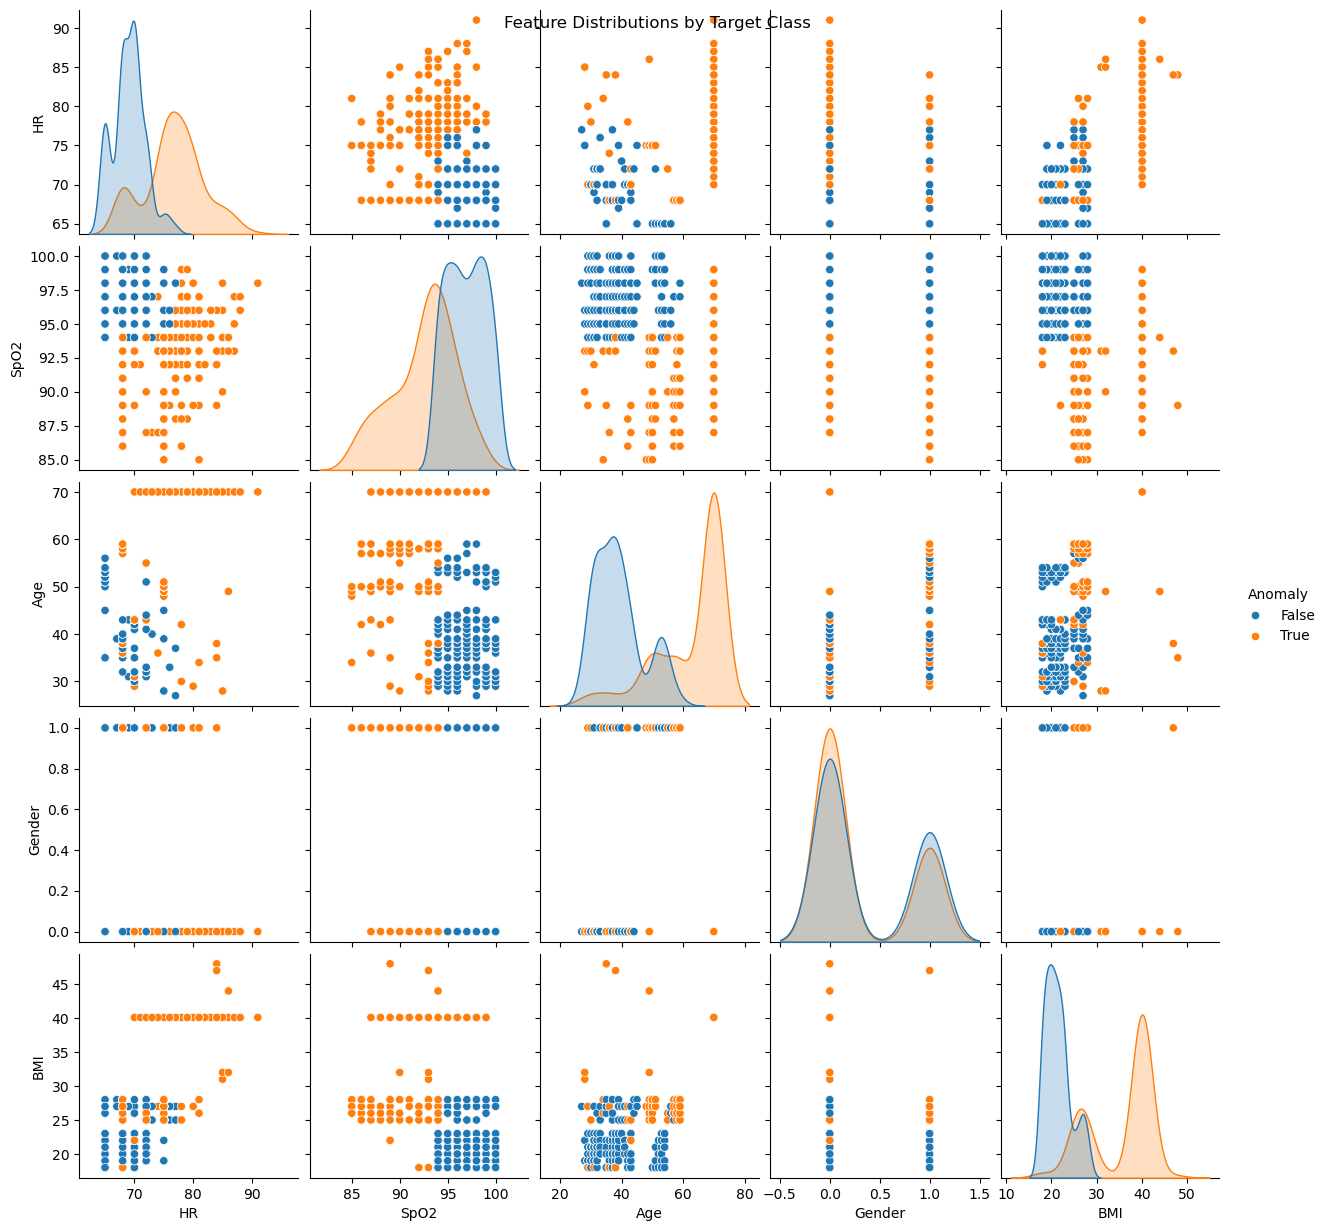

In [19]:
sns.pairplot(df, hue='Anomaly', diag_kind='kde')
plt.suptitle('Feature Distributions by Target Class')
plt.show()


Logistic Regression (with CV and GridSearch):
Best hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 1.0000, ROC AUC: 1.0000


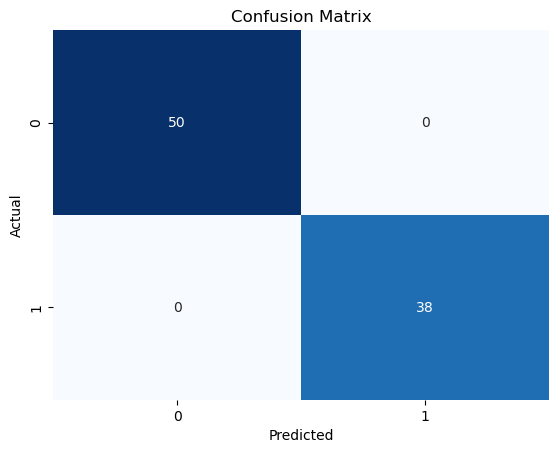

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        50
        True       1.00      1.00      1.00        38

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88


Logistic Regression (with CV):
Accuracy: 0.9886, ROC AUC: 0.9900


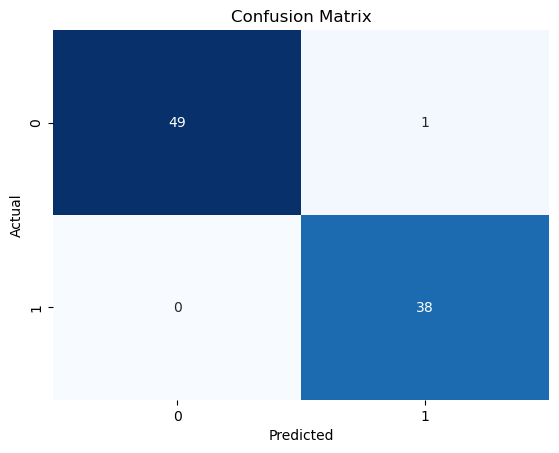

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.98      0.99        50
        True       0.97      1.00      0.99        38

    accuracy                           0.99        88
   macro avg       0.99      0.99      0.99        88
weighted avg       0.99      0.99      0.99        88


Support Vector Machine:
Accuracy: 1.0000, ROC AUC: 1.0000


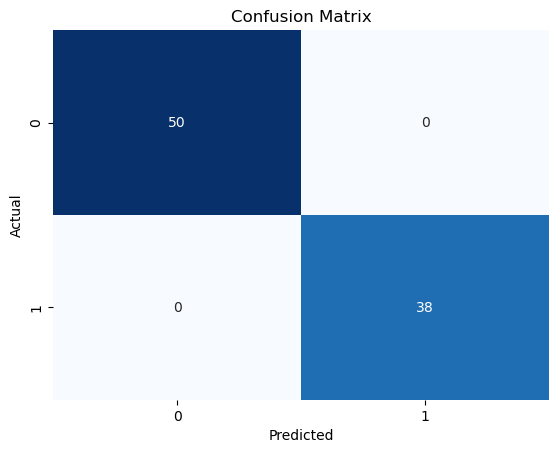

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        50
        True       1.00      1.00      1.00        38

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88


K-Nearest Neighbors:
Accuracy: 1.0000, ROC AUC: 1.0000


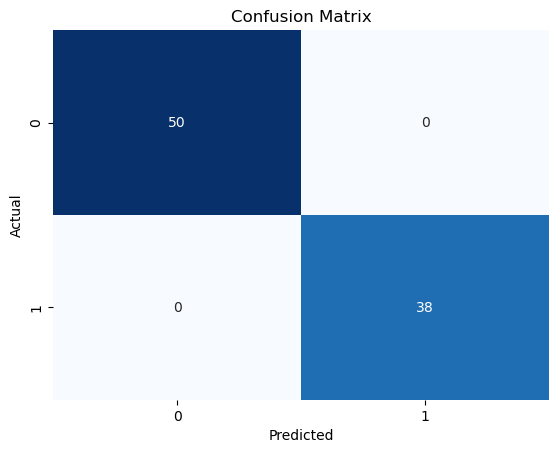

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        50
        True       1.00      1.00      1.00        38

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88


Decision Tree:
Accuracy: 1.0000, ROC AUC: 1.0000


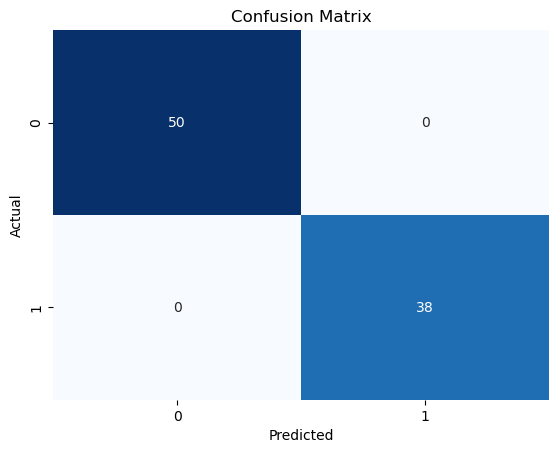

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        50
        True       1.00      1.00      1.00        38

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88


Random Forest:
Accuracy: 1.0000, ROC AUC: 1.0000


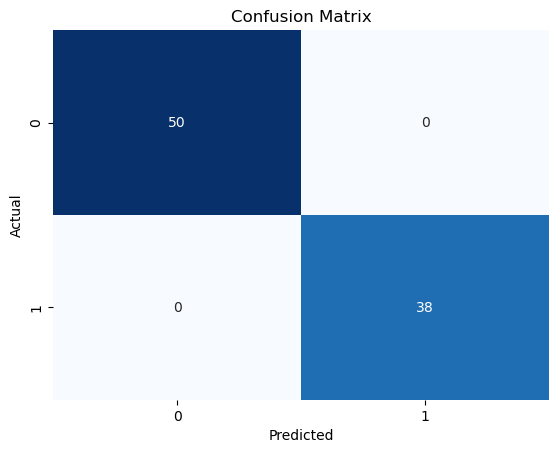

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        50
        True       1.00      1.00      1.00        38

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88



In [20]:
models = {
    'Logistic Regression (with CV and GridSearch)': LogisticRegression(),
    'Logistic Regression (with CV)': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}
model_names = list(models.keys())
accuracies = []

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{name}:")

    # Training
    if 'GridSearch' in name:
        # Perform GridSearchCV for models with hyperparameter tuning
        param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        print(f'Best hyperparameters: {best_params}')

        # Fit the model with the best parameters
        model = LogisticRegression(**best_params)
        model.fit(X_train, y_train)
    else:
        # Train the model without hyperparameter tuning
        model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)
    roc_auc = roc_auc_score(y_test, predictions)
    print(f'Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}')

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification report
    print('Classification Report:')
    print(classification_report(y_test, predictions))

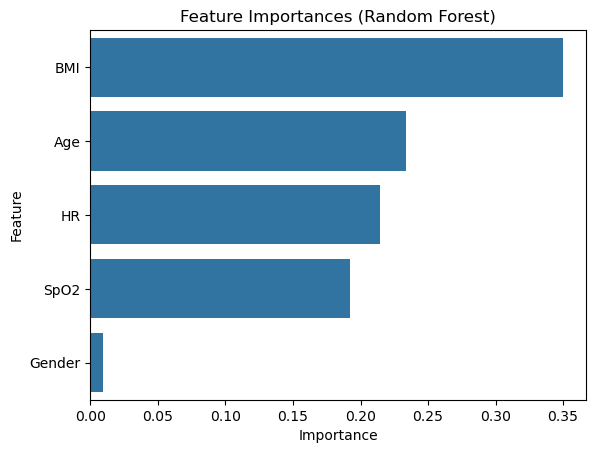

In [21]:
if isinstance(models['Random Forest'], RandomForestClassifier):
    feature_importances = models['Random Forest'].feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importances (Random Forest)')
    plt.show()

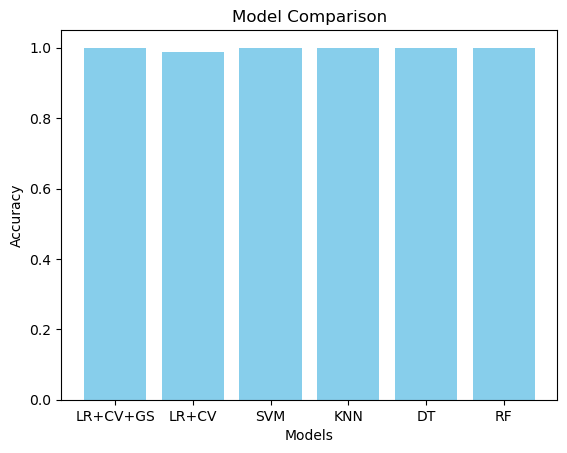

In [22]:
model_names=['LR+CV+GS', 'LR+CV','SVM','KNN','DT','RF']
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

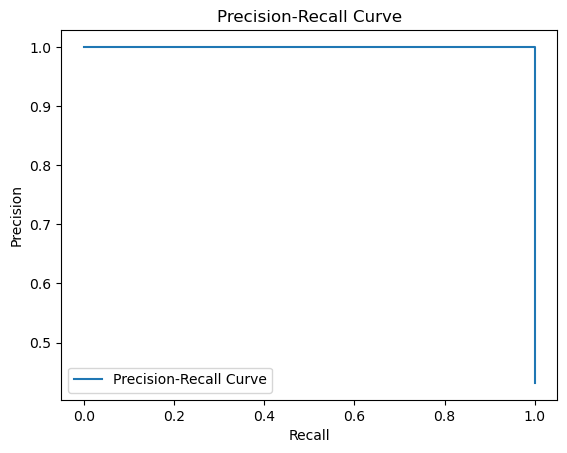

In [23]:
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

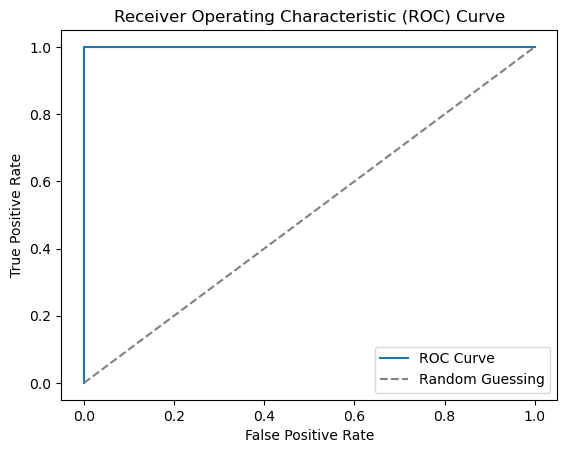

In [24]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()